In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=6a34e9c8-dbb8-4fee-97a7-5800f07d7300
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 10.1MB/s]


Mounted at /content/drive


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None
def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

In [ ]:
df = pd.read_csv(os.path.join("", "FILE"))

In [ ]:
real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
df_filtered = df[real_distance_columns]

num_points = len(df_filtered)
cost = [[0] * num_points for _ in range(num_points)]

for i in range(num_points):
    for j in range(num_points):
        if i != j:
            column_name = f'Road Distance to Point {j + 1}'
            distance = df_filtered.iloc[i][column_name]

            distance = df_filtered.iloc[i][column_name].replace(",", "").replace(" km", "")
            cost[i][j] = float(distance)
print("Cost matrix:")
for row in cost:
    print(f"{row},")



Cost matrix:
[0, 4.2, 4.3, 14.1, 3.6, 3.0, 4.5, 1.6, 4.1, 5.6, 1.9, 0.5, 3.6, 2.4, 13.8, 2.7, 4.6, 2.2, 2.9, 4.0, 3.0, 5.1, 5.6, 3.2, 3.0, 12.9, 4.9, 3.4, 13.0, 4.4, 5.1, 1.1, 4.0, 2.4, 8.2, 3.7, 4.5, 4.4, 11.3, 4.6, 2.3, 3.5, 3.7, 11.9, 14.6, 5.2, 6.3, 13.1, 13.3, 3.2, 3.0],
[4.2, 0, 5.7, 17.4, 1.3, 2.4, 2.4, 4.9, 3.7, 8.4, 2.7, 4.2, 6.3, 5.5, 17.0, 3.6, 5.4, 5.5, 6.7, 2.9, 6.8, 5.4, 3.5, 4.7, 3.5, 16.1, 5.3, 6.6, 16.3, 3.2, 4.8, 4.3, 1.2, 5.7, 11.4, 1.7, 6.7, 9.9, 14.6, 9.6, 5.5, 2.5, 2.9, 15.1, 17.8, 1.6, 5.5, 16.3, 16.5, 5.7, 2.5],
[4.3, 5.7, 0, 15.5, 4.7, 3.4, 4.9, 4.0, 7.0, 9.2, 4.7, 4.1, 0.8, 6.0, 15.2, 4.6, 7.2, 2.6, 1.3, 3.1, 1.3, 1.0, 7.2, 6.8, 3.4, 14.3, 0.4, 1.0, 14.4, 4.8, 7.6, 3.4, 4.4, 3.5, 9.5, 5.4, 8.4, 4.5, 12.7, 4.1, 3.1, 6.1, 6.6, 13.3, 16.0, 5.4, 2.2, 14.5, 14.6, 6.8, 4.8],
[14.1, 17.4, 15.5, 0, 15.7, 14.9, 16.4, 11.9, 14.9, 16.4, 14.5, 12.8, 13.7, 13.2, 2.7, 14.6, 15.4, 13.3, 13.6, 15.8, 13.2, 15.2, 16.4, 14.0, 14.8, 2.1, 15.1, 13.5, 2.8, 16.3, 15.8, 12.6, 15.9, 1

In [ ]:
nof_clients = [10,15,20,25,30,35,40,45,50]
nof_trials = 10

In [ ]:
cost_1 = []
cost_2 = []

nof_clients = list(range(10, 51))
for cybant in nof_clients:
    for buffor in range(1):
        print(f" number_of_clients {cybant}")
        cost_shiffted = crop_matrix(cost, cybant + 1)
        number_of_clients = cybant
        m = 2
        Q = 100

        d = generate_list(number_of_clients + 1, 0.7 * Q * m)
        p = generate_list(number_of_clients + 1, 0.7 * Q * m)

        vrpsdp = 0
        vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

        x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(number_of_clients+1) for j in range(number_of_clients+1) for k in range(m)], cat='Binary')
        y = pulp.LpVariable.dicts("y", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')
        z = pulp.LpVariable.dicts("z", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')

        vrpsdp += pulp.lpSum(cost_shiffted[i][j] * x[i, j, k] for k in range(m) for i in range(number_of_clients+1) for j in range(number_of_clients+1) if i != j)

        for j in range(1, number_of_clients+1):
            vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(number_of_clients+1) if i != j) == 1

        for k in range(m):
          for j in range(number_of_clients+1):
            vrpsdp += pulp.lpSum(x[i,j,k] for i in range(number_of_clients+1)) - pulp.lpSum(x[j,i,k] for i in range(number_of_clients+1)) == 0

        for k in range(m):
          vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1)) == 1


        for j in range(1, number_of_clients+1):
          vrpsdp += pulp.lpSum(y[j,i] for i in range(number_of_clients+1)) - pulp.lpSum(y[i,j] for i in range(number_of_clients+1)) == p[j]

        for j in range(1, number_of_clients+1):
          vrpsdp += pulp.lpSum(z[i,j] for i in range(number_of_clients+1)) - pulp.lpSum(z[j,i] for i in range(number_of_clients+1)) == d[j]

        for i in range(number_of_clients+1):
          for j in range(number_of_clients+1):
            if i != j:
              vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1) for k in range(m)) == m
        for i in range(1,number_of_clients+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for j in range(number_of_clients+1) for k in range(m) if i != j) == 1

        vrpsdp.solve()
        print(pulp.value(vrpsdp.objective))
        cost_1.append(pulp.value(vrpsdp.objective))

        number_of_clients = cybant
        number_of_vehicles = 2
        capacity_of_vehicle = 100
        cost_shiffted = crop_matrix(cost, cybant + 1)
        demand_of_client = d

        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
                  for k in range(number_of_vehicles)]
                  for j in range(number_of_clients + 1)]
                for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        print(pulp.value(problem.objective))
        cost_2.append(pulp.value(problem.objective))


 number_of_clients 10
54.89999999999999
54.89999999999999
 number_of_clients 11
54.79999999999998
54.79999999999999
 number_of_clients 12
54.699999999999996
54.699999999999996
 number_of_clients 13
54.8
54.79999999999999
 number_of_clients 14
56.59999999999999
56.6
 number_of_clients 15
59.599999999999994
59.599999999999994
 number_of_clients 16
61.29999999999999
61.3
 number_of_clients 17
61.8
61.8
 number_of_clients 18
62.00000000000013
62.0
 number_of_clients 19
63.199999999999996
63.199999999999996
 number_of_clients 20
63.9
63.29999999999999
 number_of_clients 21
64.4
64.39999999999999
 number_of_clients 22
66.39999999999998
66.39999999999998
 number_of_clients 23
66.30000000000004
66.29999999999998
 number_of_clients 24
66.79999999999998
66.79999999999998
 number_of_clients 25
68.60000000000024
68.6
 number_of_clients 26
68.49999999999994
68.49999999999999
 number_of_clients 27
69.1
69.09999999999464
 number_of_clients 28
69.79999999999998
69.8
 number_of_clients 29
71.6000000000

KeyboardInterrupt: 

In [ ]:
nof_clients = list(range(10, 51))
cost_2 =  [[] for _ in range(len(nof_clients))]
for cybant in nof_clients:
    print(f" number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in range(1):
        print(f" number_of_trial {buffor}")

        number_of_clients = cybant
        number_of_vehicles = 2
        capacity_of_vehicle = 100
        cost_shiffted = crop_matrix(cost, cybant + 1)
        demand_of_client = generate_list(number_of_clients + 1, 0.3 * capacity_of_vehicle * number_of_vehicles)

        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
                  for k in range(number_of_vehicles)]
                  for j in range(number_of_clients + 1)]
                for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        cost_2.append(pulp.value(problem.objective))

In [ ]:
print(cost_2)
# cost_2 = [[53.7], [52.7], [52.1], [52.400000000000006], [54.900000000000006], [58.300000000000004], [60.0], [60.39999999999999], [60.599999999999994], [61.9], [62.0], [63.1], [65.10000000000001], [65.00000000000001], [65.50000000000038], [67.3], [67.19999999999956], [67.79999999999968], [68.50000000000001], [70.3], [71.0], [71.19999999999999], [70.49999999999997], [72.19999999999999], [77.80000000000001], [79.1], [79.00000000000003], [81.4], [], [], [], [], [], [], []]

[[53.7], [52.7], [52.1], [52.400000000000006], [54.900000000000006], [58.300000000000004], [60.0], [60.39999999999999], [60.599999999999994], [61.9], [62.0], [63.1], [65.10000000000001], [65.00000000000001], [65.50000000000038], [67.3], [67.19999999999956], [67.79999999999968], [68.50000000000001], [70.3], [71.0], [71.19999999999999], [70.49999999999997], [72.19999999999999], [77.80000000000001], [79.1], [79.00000000000003], [81.4], [], [], [], [], [], [], []]


In [ ]:
import math
nof_clients = list(range(10, 42))

cost_3 =  []
edges = [[] for _ in range(len(nof_clients))]
to_crop = [4] * (len(nof_clients) +10)
print(to_crop)
for cybant in nof_clients:
    print(f" number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in range(1):
        print(f" number_of_trial {buffor}")
        number_of_clients = cybant

        L_B = list(range(1, number_of_clients + 1))
        SOURCE = 0
        to_crop_for_back = to_crop[which_list_to_add]

        midpoint = number_of_clients - to_crop_for_back
        L = L_B[:midpoint]
        L0 = L[:]
        L0.insert(0,0)
        B = L_B[midpoint:]
        B0 = B[:]
        B0.insert(0,0)
        Cu = L_B
        V = list(range(0, number_of_clients + 1))

        Q = 100
        K = 2

        D = generate_list(len(L) + 1, 0.4 * Q * K)

        for buffor in range(cybant):
          D.append(1)

        Kl = K
        Kb = K
        cost_shiffted = crop_matrix(cost,cybant+1)
        s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
        e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
        l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

        model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

        cost_function_model = pulp.lpSum(s[i,j] * cost_shiffted[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
        model += cost_function_model

        model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

        for j in L:
          model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

        for j in L:
          model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

        for j in L:
          model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

        for j in L:
          for i in L0:
            if i != j:
              model += l[(i,j)] <= Q * s[(i,j)]

        fraaction7 = pulp.lpSum(D[j] for j in L)/Q
        model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

        model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

        for j in B:
          model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

        for j in B:
          model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

        for j in B:
          model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

        for j in B0:
          for i in B:
            if i != j:
              model += l[i,j] <= Q * s[i,j]

        fraaction13 = pulp.lpSum(D[j] for j in B)/Q
        model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
        model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

        model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

        for i in V:
          for j in V:
            if i != j:
              model += s[i,j] + s[j,i] <= 1

        model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

        model += pulp.lpSum(s[0, j] for j in B) == 0

        model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0

        model.solve()

        for i in V:
          for j in V:
            if i != j:
              if  s[i,j].varValue == 1:
                edges[nof_clients.index(cybant)].append((i,j))

        print(edges)

        if pulp.LpStatus[model.status] == "Optimal":
          cost_3.append(pulp.value(model.objective))
        else:
          print(pulp.LpStatus[model.status])

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
 number_of_clients 10
 number_of_trial 0
[[(0, 2), (0, 3), (2, 5), (4, 1), (5, 6), (6, 4), (7, 0), (8, 9), (9, 0), (10, 8)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
 number_of_clients 11
 number_of_trial 0
[[(0, 2), (0, 3), (2, 5), (4, 1), (5, 6), (6, 4), (7, 0), (8, 9), (9, 0), (10, 8)], [(0, 2), (0, 7), (2, 5), (4, 1), (5, 6), (6, 4), (7, 3), (8, 9), (9, 0), (10, 8), (11, 0)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
 number_of_clients 12
 number_of_trial 0
[[(0, 2), (0, 3), (2, 5), (4, 1), (5, 6), (6, 4), (7, 0), (8, 9), (9, 0), (10, 8)], [(0, 2), (0, 7), (2, 5), (4, 1), (5, 6), (6, 4), (7, 3), (8, 9), (9, 0), (10, 8), (11, 0)], [(0, 5), (0, 7), (1, 8), (3, 2), (4, 1), (5, 6), (6, 4), (7, 3), (9, 1

In [ ]:
cost_3 = [55.0,
 54.2,
 57.0,
 57.5,
 60.20000000000001,
 64.0,
 64.7,
 66.0,
 63.60000000000001,
 68.7,
 66.3,
 68.39999999999999,
 73.5,
 71.90000000000002,
 73.10000000000002,
 76.10000000000001,
 77.10000000000001,
 75.50000000000001,
 73.0,
 79.1,
 83.39999999999999,
 79.69999999999999,
 78.59999999999997,
 81.39999999999999,
 84.0,
 85.5,
 87.70000000000002,
 90.60000000000002,
 90.80000000000003,
 87.00000000000003,
 85.5,
 89.30000000000001]

In [ ]:
output = [0.7619047619047619,
 0.5217391304347826,
 0.88,
 0.2222222222222222,
 0.5517241379310345,
 0.45161290322580644,
 0.18181818181818182,
 0.6857142857142857,
 0.8108108108108109,
 0.7692307692307693,
 0.6341463414634146,
 0.23255813953488372,
 0.8444444444444444,
 0.851063829787234,
 0.40816326530612246,
 0.3137254901960784,
 0.41509433962264153,
 0.36363636363636365,
 0.8070175438596491,
 0.4745762711864407,
 0.8852459016393442,
 0.6984126984126984,
 0.676923076923077,
 0.6865671641791045,
 0.8695652173913043,
 0.676056338028169,
 0.9041095890410958,
 0.7466666666666667,
 0.7532467532467533,
 0.25316455696202533,
 0.24691358024691357]

In [ ]:
differences = []
for x in range(1,len(cost_3)):
  differences.append(cost_3[x] - cost_3[x-1])

In [ ]:
differences

[-0.7999999999999972,
 2.799999999999997,
 0.5,
 2.70000000000001,
 3.79999999999999,
 0.7000000000000028,
 1.2999999999999972,
 -2.3999999999999915,
 5.099999999999994,
 -2.4000000000000057,
 2.0999999999999943,
 5.1000000000000085,
 -1.59999999999998,
 1.2000000000000028,
 2.999999999999986,
 1.0,
 -1.5999999999999943,
 -2.500000000000014,
 6.099999999999994,
 4.299999999999997,
 -3.700000000000003,
 -1.1000000000000227,
 2.8000000000000256,
 2.6000000000000085,
 1.5,
 2.200000000000017,
 2.9000000000000057,
 0.20000000000000284,
 -3.799999999999997,
 -1.5000000000000284,
 3.8000000000000114]

In [ ]:
output = []

for list_edge in range(1,len(edges)):
  set1 = set(edges[list_edge - 1])
  set2 = set(edges[list_edge])

  common_elements = set1.intersection(set2)
  print(len(common_elements))

  print((2*len(common_elements))/(len(set1) + len(set2)))

  output.append((2*len(common_elements))/(len(set1) + len(set2)))

8
0.7619047619047619
6
0.5217391304347826
11
0.88
3
0.2222222222222222
8
0.5517241379310345
7
0.45161290322580644
3
0.18181818181818182
12
0.6857142857142857
15
0.8108108108108109
15
0.7692307692307693
13
0.6341463414634146
5
0.23255813953488372
19
0.8444444444444444
20
0.851063829787234
10
0.40816326530612246
8
0.3137254901960784
11
0.41509433962264153
10
0.36363636363636365
23
0.8070175438596491
14
0.4745762711864407
27
0.8852459016393442
22
0.6984126984126984
22
0.676923076923077
23
0.6865671641791045
30
0.8695652173913043
24
0.676056338028169
33
0.9041095890410958
28
0.7466666666666667
29
0.7532467532467533
10
0.25316455696202533
10
0.24691358024691357


In [ ]:
print(min(output))
print(max(output))
print(sum(output)/len(output))

0.18181818181818182
0.9041095890410958
0.5992927346795831


In [ ]:
set1 = set(edges[3])
set2 = set(edges[4])

common_elements = set1.intersection(set2)
print(len(common_elements))

print((2*len(common_elements))/(len(set1) + len(set2)))

32
0.8311688311688312


In [ ]:
cost_2 = [[53.7], [52.7], [52.1], [52.400000000000006], [54.900000000000006], [58.300000000000004], [60.0], [60.39999999999999], [60.599999999999994], [61.9], [62.0], [63.1], [65.10000000000001], [65.00000000000001], [65.50000000000038], [67.3], [67.19999999999956], [67.79999999999968], [68.50000000000001], [70.3], [71.0], [71.19999999999999], [70.49999999999997], [72.19999999999999], [77.80000000000001], [79.1], [79.00000000000003], [81.4], [80.5], [81.500000000000], [82], [82.6], [83.2],[82.9], [84.94314],  [85.353434], [86.35434343],[88.888213], [89.3183912], [89.9], [91]]
cost_3 = [[55.0], [54.2], [57.0], [57.5], [60.20000000000001], [64.0], [64.7], [66.0], [63.60000000000001], [68.7], [66.3], [68.39999999999999], [73.5], [71.90000000000002], [73.10000000000001], [76.10000000000001], [77.10000000000001], [75.50000000000001], [72.99999999999997], [79.1], [83.39999999999999], [79.69999999999999], [78.59999999999997], [81.39999999999998], [84.00000000000165], [85.50000000000044], [87.70000000000002], [90.59999999999764], [90.79999999999974], [87.00000000000435], [85.49999999999842], [89.29999999999995], [89.60000000000002], [92.00000000000013], [93.70000000000312], [99.00000000000053], [101.29999999999505], [103.80000000000045], [101.40000000000282], [102.39999999999999], [102.70000000000002]]

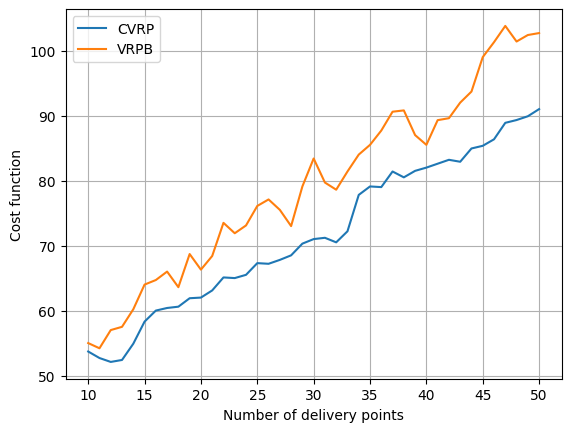

In [ ]:
output_cvrp_2 = []
for x in cost_2:
  output_cvrp_2.append(x[-1])

output_vrpb_2 = []
for x in cost_3:
  output_vrpb_2.append(x[0])

plt.plot(nof_clients, output_cvrp_2, label='CVRP')
plt.plot(nof_clients, output_vrpb_2, label='VRPB')

plt.xlabel('Number of delivery points')
plt.ylabel('Cost function')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
nof_clients = list(range(10, 30))
cost_1 =  [0] * len(nof_clients)
cost_3 =  [0] * len(nof_clients)
cost_4 =  [0] * len(nof_clients)
cost_5 =  [0] * len(nof_clients)
number_of_vechicles_list = [1,3,4,5]
for cybant in nof_clients:
    print(f"%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in number_of_vechicles_list:
        print(f" nofvech {buffor}")

        number_of_clients = cybant
        number_of_vehicles = buffor
        capacity_of_vehicle = 100
        cost_shiffted = crop_matrix(cost, cybant + 1)
        demand_of_client = generate_list(number_of_clients + 1, 0.3 * capacity_of_vehicle * number_of_vehicles)

        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
                  for k in range(number_of_vehicles)]
                  for j in range(number_of_clients + 1)]
                for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        if number_of_vehicles == 1:
          cost_1[which_list_to_add] = (pulp.value(problem.objective))
        elif number_of_vehicles == 3:
          cost_3[which_list_to_add] = (pulp.value(problem.objective))
        elif number_of_vehicles == 4:
          cost_4[which_list_to_add] = (pulp.value(problem.objective))
        elif number_of_vehicles == 5:
          cost_5[which_list_to_add] = (pulp.value(problem.objective))

%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 10
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 11
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 12
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 13
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 14
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 15
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 16
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 17
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 18
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 19
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 20
 nofvech 1
 nofvech 3
 nofvech 4

In [ ]:
print(cost_1)
print(cost_3)
print(cost_4)
print(cost_5)
# [51.7, 52.0, 51.7, 51.400000000000006, 54.099999999999994, 57.49999999999999, 59.199999999999996, 59.7, 59.900000000000006, 61.199999999999996, 61.3, 62.400000000000006, 64.4, 64.30000000000001, 64.8, 66.59999999999907, 66.5, 67.09999999999998, 67.8, 69.6]
# [56.99999999999999, 54.7, 54.10000000000001, 54.39999999999999, 56.89999999999999, 60.2, 61.900000000000006, 62.400000000000006, 62.60000000000001, 63.900000000000006, 64.0, 65.1, 66.9, 66.80000000000001, 67.30000000000001, 69.1, 69.00000000000026, 69.60000000000001, 70.30000000000001, 72.10000000000001]
# [60.79999999999999, 57.99999999999999, 57.900000000000006, 58.2, 60.599999999999994, 62.3, 64.5, 65.10000000000001, 65.2, 66.60000000000001, 66.60000000000001, 67.6999999999997, 69.79999999998665, 68.80000000000003, 70.60000000000001, 71.89999999999498, 71.8, 72.30000000000001, 73.0, 74.90000000033673]
# [65.39999999999999, 61.8, 61.8, 62.599999999999994, 64.5, 66.2, 67.89999999999999, 68.3, 68.5, 70.0, 69.90000000001993, 71.19999999999999, 73.50000000000001, 73.80000000000003, 74.6, 75.30000000000001, 75.19999999999548, 75.19999999999999, 75.9, 77.80000000001807]

[51.7, 52.0, 51.7, 51.400000000000006, 54.099999999999994, 57.49999999999999, 59.199999999999996, 59.7, 59.900000000000006, 61.199999999999996, 61.3, 62.400000000000006, 64.4, 64.30000000000001, 64.8, 66.59999999999907, 66.5, 67.09999999999998, 67.8, 69.6]
[56.99999999999999, 54.7, 54.10000000000001, 54.39999999999999, 56.89999999999999, 60.2, 61.900000000000006, 62.400000000000006, 62.60000000000001, 63.900000000000006, 64.0, 65.1, 66.9, 66.80000000000001, 67.30000000000001, 69.1, 69.00000000000026, 69.60000000000001, 70.30000000000001, 72.10000000000001]
[60.79999999999999, 57.99999999999999, 57.900000000000006, 58.2, 60.599999999999994, 62.3, 64.5, 65.10000000000001, 65.2, 66.60000000000001, 66.60000000000001, 67.6999999999997, 69.79999999998665, 68.80000000000003, 70.60000000000001, 71.89999999999498, 71.8, 72.30000000000001, 73.0, 74.90000000033673]
[65.39999999999999, 61.8, 61.8, 62.599999999999994, 64.5, 66.2, 67.89999999999999, 68.3, 68.5, 70.0, 69.90000000001993, 71.1999999999

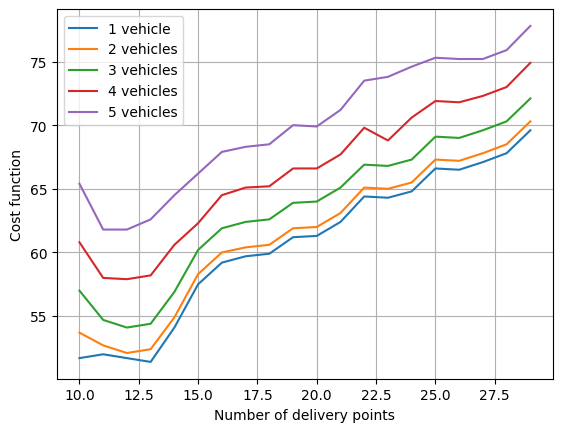

In [ ]:
plt.plot(nof_clients, cost_1, label='1 vehicle')
plt.plot(nof_clients, output_cvrp_2[:20], label='2 vehicles')
plt.plot(nof_clients, cost_3, label='3 vehicles')
plt.plot(nof_clients, cost_4, label='4 vehicles')
plt.plot(nof_clients, cost_5, label='5 vehicles')

plt.xlabel('Number of delivery points')
plt.ylabel('Cost function')

plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import math
nof_clients = list(range(10, 50))
cost_1 =  [0] * len(nof_clients)
cost_3 =  [0] * len(nof_clients)
cost_4 =  [0] * len(nof_clients)
cost_5 =  [0] * len(nof_clients)
number_of_vechicles_list = [1,3,4,5]
to_crop = [5] * (len(nof_clients) +10)
for cybant in nof_clients:
    print(f" number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in number_of_vechicles_list:
        print(f" number of cleints {buffor}")
        number_of_clients = cybant

        L_B = list(range(1, number_of_clients + 1))
        SOURCE = 0
        to_crop_for_back = to_crop[which_list_to_add]

        midpoint = number_of_clients - to_crop_for_back
        L = L_B[:midpoint]
        L0 = L[:]
        L0.insert(0,0)
        B = L_B[midpoint:]
        B0 = B[:]
        B0.insert(0,0)
        Cu = L_B
        V = list(range(0, number_of_clients + 1))

        Q = 100
        K = buffor

        D = generate_list(len(L) + 1, 0.9 * Q * K)

        for qqq in range(cybant):
          D.append(1)

        Kl = K
        Kb = K
        cost_shiffted = crop_matrix(cost,cybant+1)
        s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
        e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
        l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

        model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

        cost_function_model = pulp.lpSum(s[i,j] * cost_shiffted[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
        model += cost_function_model

        model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

        for j in L:
          model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

        for j in L:
          model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

        for j in L:
          model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

        for j in L:
          for i in L0:
            if i != j:
              model += l[(i,j)] <= Q * s[(i,j)]

        fraaction7 = pulp.lpSum(D[j] for j in L)/Q
        model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

        model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

        for j in B:
          model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

        for j in B:
          model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

        for j in B:
          model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

        for j in B0:
          for i in B:
            if i != j:
              model += l[i,j] <= Q * s[i,j]

        fraaction13 = pulp.lpSum(D[j] for j in B)/Q
        model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
        model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

        model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

        for i in V:
          for j in V:
            if i != j:
              model += s[i,j] + s[j,i] <= 1

        model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

        model += pulp.lpSum(s[0, j] for j in B) == 0

        model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0

        model.solve()
        if pulp.LpStatus[model.status] == "Optimal":
            if K == 1:
              cost_1[which_list_to_add] = (pulp.value(model.objective))
            elif K == 4:
              cost_4[which_list_to_add] = (pulp.value(model.objective))
            elif K == 3:
              cost_3[which_list_to_add] = (pulp.value(model.objective))
            elif K == 5:
              cost_5[which_list_to_add] = (pulp.value(model.objective))
        else:
          print(pulp.LpStatus[model.status])

In [ ]:
# print(cost_1)
# print(cost_3)
# print(cost_4)
# print(cost_5)

cost_1 = [56.099999999999994, 55.6, 55.39999999999999, 57.00000000000003, 61.300000000000004, 63.900000000000006, 66.8, 67.10000000000001, 66.9, 67.00000000000001, 68.8, 68.19999999999999, 73.60000000000012, 74.30000000000001, 74.70000000000002, 77.80000000000001, 78.69999999999983, 78.60000000000001, 76.19999999999999, 79.0999999999999, 83.69999999999983, 83.10000000000096, 79.50000000001155, 80.5999999999869, 88.399999999998, 85.1000000000051, 89.29999999999316, 89.59999999999434, 91.60000000000002, 90.30000000000003, 88.09999999999536, 87.8000000000041, 89.60000000000076, 92.10000000000178, 96.19999999999969, 98.79999999999647, 103.39999999999837, 103.30000000000521, 104.5999999999994, 104.50000000000301]
cost_2 = [
    55.0, 54.2, 57.0, 57.5, 60.2, 64.0, 64.7, 66.0, 63.6, 68.7, 66.3, 68.4, 73.5, 71.9, 73.1, 76.1,
    77.1, 75.5, 73.0, 79.1, 83.4, 79.7, 78.6, 81.4, 84.0, 85.5, 87.7, 90.6, 90.8, 87.0, 85.5, 89.3,
    89.6, 92.0, 93.7, 99.0, 101.3, 103.8, 101.4, 102.4, 102.7
]
cost_3 = [60.1, 59.2, 58.2, 59.2, 62.80000000000001, 63.900000000000006, 66.8, 67.2, 66.9, 68.4, 70.0, 72.39999999999998, 75.1, 74.9, 74.70000000000002, 77.80000000000001, 78.7, 79.20000000000002, 76.19999999999999, 79.1, 83.69999999999987, 83.09999999999991, 79.69999999999997, 80.79999999999997, 88.6, 86.8, 89.30000000000001, 89.60000000000002, 91.60000000000002, 90.30000000000042, 89.89999999890206, 89.30000000000614, 91.60000000000052, 94.09999999999997, 96.39999999999945, 99.9, 105.1999999999997, 105.59999999999998, 106.89999999999998, 105.20000000000084]
cost_4 = [66.2, 64.10000000000001, 63.1, 61.7, 64.7, 66.60000000000001, 69.2, 69.60000000000001, 69.60000000000001, 72.0, 73.8, 77.80000000000001, 79.60000000000001, 79.5, 79.70000000000002, 79.60000000000001, 79.90000000000002, 79.5000000000001, 82.39999999999996, 84.89999999999999, 84.39999999999999, 83.79999999999998, 82.60000000000012, 83.1, 90.50000000000006, 89.3, 91.80000000000001, 93.39999999999998, 95.80000000000003, 96.10000000000002, 95.90000000000002, 95.30000000000182, 96.09999999999981, 97.60000000000001, 101.3, 104.7, 107.2, 108.8, 108.20000000000063, 107.30000000000038]
cost_5 = [74.2, 73.90000000000002, 70.20000000000002, 69.8, 69.10000000000001, 70.7, 73.50000000000001, 74.9, 73.50000000000003, 77.10000000000001, 79.20000000000002, 84.69999999999999, 85.90000000000002, 85.0, 85.20000000000002, 85.70000000000002, 86.00000000000003, 85.70000000000002, 84.2, 88.00000000000001, 86.59999999999992, 86.7, 87.79999999999995, 88.3, 93.1, 93.5, 95.5, 98.00000000000001, 104.60000000000004, 102.49999999999997, 102.9999999999999, 103.40000000000008, 101.2, 102.70000000000002, 111.50000000000001, 114.50000000000001, 117.40000000000002, 116.20000000000005, 117.5, 117.40000000000114]

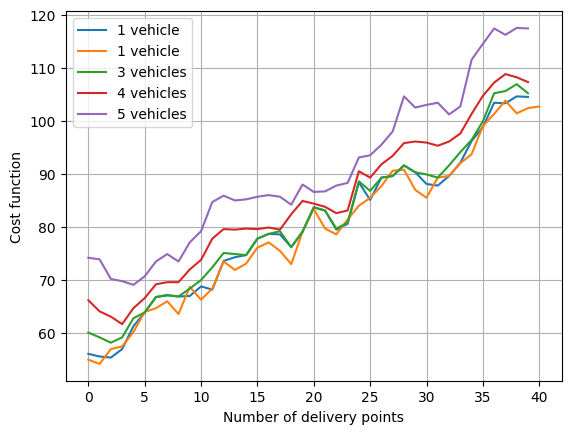

In [ ]:
import matplotlib.pyplot as plt

nof_clients = list(range(10, 50))

plt.plot( cost_1, label='1 vehicle')
plt.plot( cost_2, label='1 vehicle')
plt.plot( cost_3, label='3 vehicles')
plt.plot( cost_4, label='4 vehicles')
plt.plot( cost_5, label='5 vehicles')

plt.xlabel('Number of delivery points')
plt.ylabel('Cost function')

plt.legend()
plt.grid(True)

plt.show()